<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/09_TC1_Clustered_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [1]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)

In [4]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')

In [5]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [6]:
# outcome = encode(outcome['Project_id'])

In [7]:
TC1data15['project_id_name'] = outcome['Project_id_name']
TC1data15['project_id'] = outcome['Project_id']


In [8]:
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.897300,0.000000,1.829995,0.656801,0.001333,0.528604,2.618544,1.993496,1.487510,1.049062,0.000000,0.258848,1.455348,0.853410,1.215961,0.000000,0.571925,0.644190,0.536399,0.215012,0.0,1.704930,2.033992,2.059344,0.000000,0.000000,0.0,0.0,0.811806,1.861269,1.084387,2.724172,1.159409,0.000000,0.000000,0.193960,1.282674,0.685311,0.463778,0.899169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [9]:
TC1data15_cluster = TC1data15.copy()
TC1data15_cluster['project_id_name'] = TC1data15_cluster['project_id_name'].replace(['TCGA-CESC','TCGA-LUSC','TCGA-BLCA','TCGA-HNSC'],'SCC')
TC1data15_cluster['project_id'] = TC1data15_cluster['project_id'].replace([0,2,4,9],0)

In [10]:
TC1data15_cluster

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.897300,0.000000,1.829995,0.656801,0.001333,0.528604,2.618544,1.993496,1.487510,1.049062,0.000000,0.258848,1.455348,0.853410,1.215961,0.000000,0.571925,0.644190,0.536399,0.215012,0.0,1.704930,2.033992,2.059344,0.000000,0.000000,0.0,0.0,0.811806,1.861269,1.084387,2.724172,1.159409,0.000000,0.000000,0.193960,1.282674,0.685311,0.463778,0.899169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [11]:
cluster_300 = TC1data15_cluster[(TC1data15_cluster['project_id_name'] == 'SCC')].copy().sample(n = 300)
TC1data15_reduced = TC1data15_cluster[(TC1data15_cluster['project_id_name'] != 'SCC')].copy()
TC1data15_reduced = TC1data15_reduced.append(cluster_300)
TC1data15_reduced

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.000000,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.000000,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.000000,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.000000,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.000000,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.000000,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.000000,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.000000,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.000000,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.000000,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,1.516640,0.000000,1.978480,0.837059,0.880983,0.936920,1.956416,1.968322,1.176867,1.559317,0.928271,1.298009,1.644698,0.531276,1.903113,0.408943,1.520717,0.430571,1.173108,0.538518,0.967471,1.689169,2.178713,2.397465,1.029280,0.000000,0.0,0.124031,1.269687,2.306293,1.599707,1.204738,1.801507,0.492781,0.097283,0.736545,0.000000,0.982

In [12]:
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([13],2)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([14],4)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([15],9)
TC1data15_reduced


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.000000,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.000000,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.000000,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.000000,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.000000,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.000000,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.000000,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.000000,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.000000,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.000000,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,1.516640,0.000000,1.978480,0.837059,0.880983,0.936920,1.956416,1.968322,1.176867,1.559317,0.928271,1.298009,1.644698,0.531276,1.903113,0.408943,1.520717,0.430571,1.173108,0.538518,0.967471,1.689169,2.178713,2.397465,1.029280,0.000000,0.0,0.124031,1.269687,2.306293,1.599707,1.204738,1.801507,0.492781,0.097283,0.736545,0.000000,0.982

# ConvNN

## Train/Test split    

In [13]:
TC1data15_reduced['project_id'].unique()

array([10,  8, 11,  7,  1, 12,  2,  4,  3,  5,  6,  0])

In [14]:
# from keras.utils import to_categorical
TC1data15_selected = TC1data15_reduced.iloc[:,:-2]
outcome = encode(TC1data15_reduced['project_id'])
TC1data15_selected.shape, outcome.shape

Shape of data (BEFORE encode): (3600,)
Shape of data (AFTER  encode): (3600, 13)



((3600, 60483), (3600, 13))

In [15]:
TC1data15_selected

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.000000,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.000000,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.000000,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.000000,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.000000,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.000000,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.000000,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.000000,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.000000,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.000000,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,1.516640,0.000000,1.978480,0.837059,0.880983,0.936920,1.956416,1.968322,1.176867,1.559317,0.928271,1.298009,1.644698,0.531276,1.903113,0.408943,1.520717,0.430571,1.173108,0.538518,0.967471,1.689169,2.178713,2.397465,1.029280,0.000000,0.0,0.124031,1.269687,2.306293,1.599707,1.204738,1.801507,0.492781,0.097283,0.736545,0.000000,0.982166,0.993243,1.302029,..

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [17]:
X_train

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
78,1.885813,0.187967,2.099621,0.530456,0.287518,0.856166,1.139724,1.670351,0.713450,1.088616,0.208508,0.511565,1.211061,0.793983,1.161246,1.282486,1.174487,0.000000,0.796000,0.690147,0.0,1.892512,1.792898,2.234675,0.405659,1.054682,0.000000,0.000000,1.001592,1.751379,1.119224,1.389769,1.412469,0.000000,0.000000,1.138392,0.504616,0.631240,1.108917,0.994162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1425,1.841831,1.797445,1.760629,0.652259,0.345951,1.179842,1.827793,2.138120,1.244237,1.349769,0.375966,1.073730,1.250092,1.548894,1.776373,0.000000,1.780881,0.464831,1.274974,0.393860,0.0,1.882756,2.102405,2.025748,0.240647,2.597758,0.000000,0.426635,1.010052,2.074525,1.170427,2.896914,1.940423,0.900209,0.205308,1.154345,1.164251,1.104602,1.066641,1.432045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,1.347683,0.426623,2.135318,0.739056,0.646764,1.292953,1.950159,2.028842,0.556162,1.623860,0.605804,1.294726,1.388618,0.483318,1.753489,0.000000,1.283242,0.386203,1.231172,0.861473,0.0,1.759002,2.298318,2.280944,0.785273,0.000000,0.000000,0.000000,1.067428,2.133968,1.432077,1.650470,1.820146,0.165070,0.668022,0.708933,0.000000,0.897738,0.781908,1.378725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3076,1.796239,0.000000,1.945952,0.941368,0.488932,1.343606,1.993279,1.890275,1.349299,1.689408,0.804995,1.877351,1.458285,1.398399,1.954047,0.166371,1.470834,0.749334,1.337133,1.073121,0.0,1.798494,1.898866,1.861915,0.452225,0.255862,0.000000,0.000000,1.317325,2.149870,1.410077,1.273791,2.091340,0.306092,0.613417,1.092229,1.058321,0.959923,0.682468,1.547397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2536,0.900941,0.325608,1.027099,0.179533,0.000000,0.737270,1.022524,1.548356,0.696624,0.751480,0.353358,0.458528,1.064779,0.797745,1.464484,0.000000,0.981839,0.000000,0.184398,0.000000,0.0,1.974410,0.945475,2.390680,0.000000,0.000000,0.000000,0.000000,0.997745,1.559411,1.129429,1.870401,1.117060,0.000000,0.027390,0.392106,0.656718,0.106230,0.400551,0.847776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,1.376393,0.000000,1.807366,0.641510,0.553181,0.904113,1.038795,1.756699,0.751231,1.311912,0.625308,0.945854,1.258520,1.045241,1.649713,1.104079,1.137928,0.000000,0.923609,1.043059,0.0,1.721245,1.893244,1.976770,0.056894,0.628496,0.000000,0.000000,1.042224,1.998885,1.082732,1.494303,1.415101,0.000000,0.374524,1.025721,1.182975,0.678523,0.703038,0

## CONV1D 

In [18]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [19]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [20]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60464, 128)        2688      
_________________________________________________________________
activation (Activation)      (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60464, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_1 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 773760)            0

In [21]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_reduced'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [22]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)
early_stop = EarlyStopping(monitor='loss', patience=5)

In [23]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr, early_stop])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 1602s 12s/step - loss: 2.8206 - acc: 0.0957 - val_loss: 2.4740 - val_acc: 0.0844

Epoch 00001: val_loss improved from inf to 2.47401, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 1608s 12s/step - loss: 2.1259 - acc: 0.2867 - val_loss: 0.4613 - val_acc: 0.8344

Epoch 00002: val_loss improved from 2.47401 to 0.46129, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 1626s 12s/step - loss: 0.5656 - acc: 0.8103 - val_loss: 0.5675 - val_acc: 0.7878

Epoch 00003: val_loss did not improve from 0.46129
Epoch 4/30
135/135 [==============================] - 1663s 12s/step - loss: 0.2785 - acc: 0.9155 - val_loss: 0.1990 - val_acc: 0.9478

Epoch 00004: val_loss improved from 0.46129 to 0.19900, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosav

In [24]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.04237566143274307
Test accuracy: 0.9911110997200012


Text(0.5, 0, 'epoch')

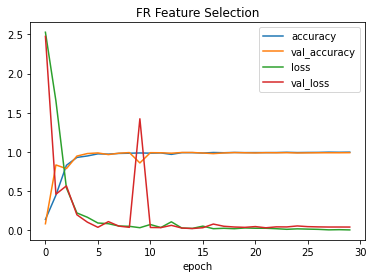

In [25]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [26]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [27]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [28]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.04237566143274307
Test accuracy: 0.9911110997200012
accuracy: 99.11%
